In [1]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac

from itertools import product


In [2]:
# GridWorld

ALPHA_Q = 0.9
ALPHA_TLR = 0.001
GAMMA = 0.99
E = 50_000
H = 5
EPS = 1.0
EPS_DECAY = 0.9999
K = 8
SCALE = 0.1

ENV = GridWorldEnv()

DISCRETIZER = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

fhq_learner = FHQLearning(DISCRETIZER, ALPHA_Q, H)

_ = run_experiment(0, E, H, EPS, EPS_DECAY, ENV, fhq_learner)

mat_q = np.max(fhq_learner.Q, axis=3)[0].reshape(ENV.W, ENV.W)



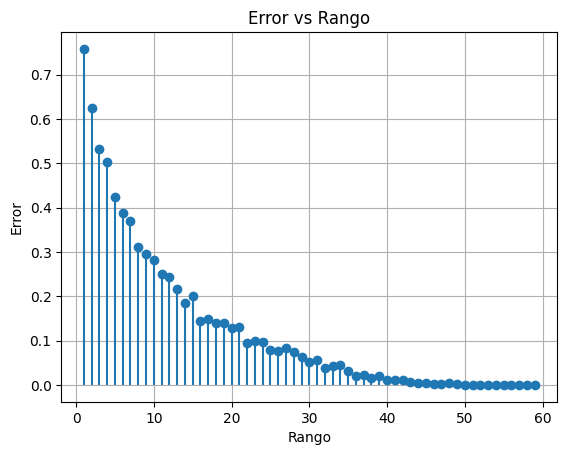

In [4]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(fhq_learner.Q, "P1")

In [8]:
# Creamos la función Q
discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)
Q = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )

In [9]:
nS = ENV.nS
nA = ENV.nA
W = ENV.W
R = ENV.R
P = ENV.P

bp_learner = BackwardPropagation(H,nS,nA,R,P)
fpi_learner = FrontPolicyImprovement(H,nS,nA,R,P)
bpi_learner = BackPolicyImprovement(H,nS,nA,R,P)

_ = bp_learner.run()
_, error_fpi = fpi_learner.run()
_, error_bpi = bpi_learner.run()

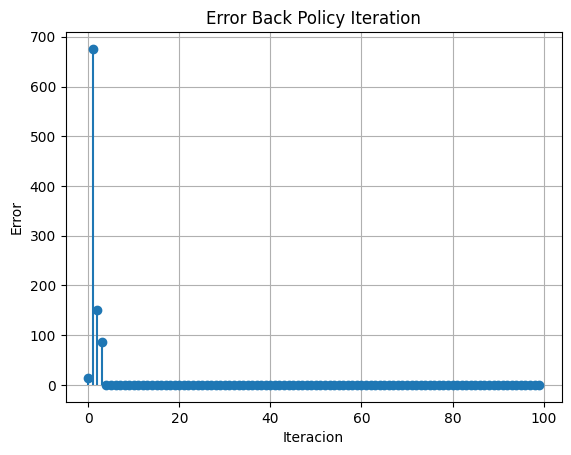

In [107]:
plt.stem(error_fpi, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()


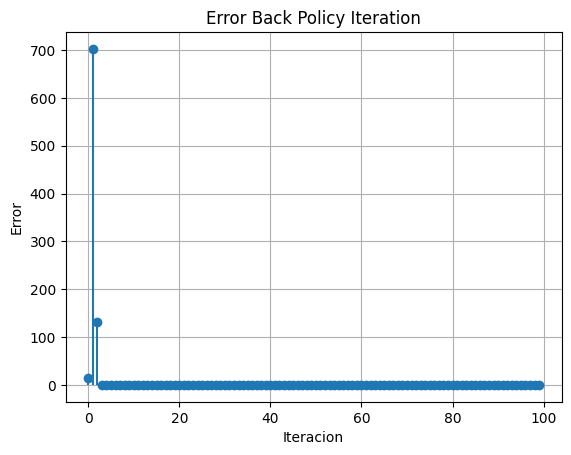

In [108]:
plt.stem(error_bpi, basefmt=" ")
plt.title("Error Back Policy Iteration")
plt.xlabel("Iteracion")
plt.ylabel("Error")
plt.grid(True)
plt.show()


BACKGUARDS INDUCTION

In [85]:
Q = np.zeros(
            np.concatenate([[H], [nS], [nA]])
        )
R_sa = np.sum(np.multiply(R, P),axis=0)
for h in range(1,H+1):
    if h == 1:
        Q[H-h,:,:] = R_sa
    else:
        Q[H-h,:,:] = R_sa + np.sum((P*np.max(Q[H-(h-1),:,:], axis=1)[:,np.newaxis,np.newaxis]),axis=0)

Q_BP = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )
for h in range(H):
    for a in range(nA):
        Q_BP[h,:,:,a] = np.transpose(Q[h,:,a].reshape((5,5)))

print(np.linalg.norm(fhq_learner.Q[:,:,:,:]-Q_BP))

In [102]:
Q_reshape = np.zeros(
    np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
)
for h in range(H):
    for nA, a in enumerate(product(*[ np.arange(0,da) for da in discretizer.bucket_actions])):
        Q_reshape [h,...,a] = np.transpose(Q[h,:,nA].reshape(*discretizer.bucket_states))


In [103]:
print(np.linalg.norm(Q_reshape[:,:,:,:]-Q_BP[:,:,:,:]))

0.0


POLICY ITERATION

In [10]:
R_sa = np.sum(np.multiply(R, P),axis=0)
P_sa_s = np.transpose(P, (1, 2, 0))
Q = np.zeros(
            np.concatenate([[H], [nS], [nA]])
        )
def policy_evaluation1(Pi):
    V = np.zeros((H,nS))
    for _ in range(100):
        for h in range(H):
            P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi[h,:])
            R_s = np.einsum('ij, ij -> i', R_sa, Pi[h,:])
            V[h,:] = R_s
            if h < H-1 :
                V[h,:] += P_s_s @ V[h+1,:]
        
    Q = np.roll((R_sa[:,:,np.newaxis] +P_sa_s @ np.transpose(V)), shift=-1, axis=2)
    Q[:,:,H-1] = R_sa
    return V, np.transpose(Q,(2,0,1))

def policy_evaluation2(Pi):
    V = np.zeros((H,nS))
    R_h_sa = np.zeros((H,nS,nA))
    for h in range(1,H+1):
        P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi[H-h,:])
        R_s = np.einsum('ij, ij -> i', R_sa, Pi[H-h,:])
        if h == 1:
            V[H-h,:] = R_s
        else:
            V[H-h,:] = R_s + P_s_s @ V[H-(h-1),:]
    for h in range(H):
        if h == H-1:
            Q[h,:,:] = R_sa
        else:
            Q[h,:,:] = R_sa +P_sa_s @ V[h+1,:]  
    return V, Q


def policy_improvement(Q):
    Pi = np.zeros((H,nS, nA))
    for h in range(H):
        for s in range(nS):
            a = np.argmax(Q[h, s, :])
            Pi[h,s, a] = 1
    return Pi

V_old = np.zeros((H,nS))
Q_old = np.zeros((H,nS, nA))
Pi = np.random.rand(H,nS, nA)
Pi /= Pi.sum(axis=1, keepdims=True)
error_plicy = []
for _ in range(100):
    V, Q = policy_evaluation1(Pi)
    Pi = policy_improvement(Q)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_plicy.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q

V_policy = V
Q_policy = np.zeros(
            np.concatenate([[H], discretizer.bucket_states, discretizer.bucket_actions])
        )
for h in range(H):
    for a in range(nA):
        Q_policy[h,:,:,a] = np.transpose(Q[h,:,a].reshape((5,5)))

In [11]:
print(np.linalg.norm(fhq_learner.Q[:,:,:,:]-Q_policy[:,:,:,:]))

0.01019446942482654
